In [1]:
import torch
import torch.nn as nn
from torch.nn.functional import *
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import math
import matplotlib.animation as animation
from sklearn.metrics import pairwise_distances
from mpl_toolkits import mplot3d
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
def isomorphism(x):
    a,b,c = x
    return torch.Tensor([[0,-c,b],[c,0,-a],[-b,a,0]])

In [3]:
I_1,I_2,I_3 = 1,2,3
M_1,M_2,M_3 = 3,2,1
m = 1
g = 9.8
r_G = torch.Tensor([1,1,1])

M = torch.diag(torch.Tensor([M_1,M_2,M_3]))
I = torch.diag(torch.Tensor([I_1,I_2,I_3]))
D = m*isomorphism(r_G)
C = torch.linalg.inv(M-D.T@torch.linalg.inv(I)@D)
A = torch.linalg.inv(I-D@torch.linalg.inv(M)@D.T)
B = -torch.linalg.inv(M)@D.T@A

def Ham(y):
    Q = torch.cat((torch.cat((A, B.T, torch.zeros(3,3)), axis = 1), torch.cat((B, C, torch.zeros(3,3)), axis = 1), torch.zeros(3,9)), axis = 0)
    return 0.5*(y.T@Q@y)-m*g*(y.T@torch.cat((torch.zeros(6),r_G)))

In [4]:
def K(x, y, rho):
    # Compute pairwise value of RBF/Gaussian kernel
    distances = torch.cdist(x, y, p=2)
    kernel_matrix = torch.exp(-distances**2 / (rho **2))
    return kernel_matrix

def K_1_2(train_data, rho):
    #Compute the Differential Gram matrix
    n, d = train_data.shape
    view1 = train_data.view(n,1,d,1)
    view2 = train_data.view(1,n,d,1)
    diff1 = view1-view2
    diff2 = diff1.view(n,n,1,d)
    temp = torch.matmul(diff1, diff2)
    temp = torch.cat(list(temp),1)
    temp = torch.cat(list(temp),1)
    temp = (-4/rho**4)*temp+(2/rho**2)*torch.tile(torch.eye(d),(n,n))
    scalar = Gram(train_data, rho)
    scalar = torch.permute(scalar.expand(d**2,n,n),(1,2,0)).view(n,n,d,d)
    scalar = torch.cat(list(scalar),1)
    scalar = torch.cat(list(scalar),1)
    return scalar*temp
    

def Gram(data, rho):
    # Get the number of data points
    num_points = data.size(0)

    # Reshape data to (N, 1, D) and (1, N, D) to allow broadcasting
    data_i = data.view(num_points, 1, -1)
    data_j = data.view(1, num_points, -1)

    # Compute the Gram matrix using vectorized operations
    gram_matrix = K(data_i, data_j, rho).view(num_points, num_points)

    return gram_matrix

def Gram_single(train_data, data, rho):
    num_points = train_data.size(0)
    data_i = train_data.view(num_points,1,-1)
    data_j = data.view(1,1,-1)
    gram_matrix = K(data_i, data_j, rho).view(num_points, 1)
    return gram_matrix

def K_1_Gram_single(train_data, data, rho):
    return ((-2.0/rho**2)*Gram_single(train_data, data, rho)*(train_data-data)).flatten()

def K_1_2_Gram_single(train_data, data, rho):
    n, d = train_data.shape
    view1 = train_data.view(n,1,d,1)
    view2 = data.view(1,1,d,1)
    diff1 = view1-view2
    diff2 = diff1.view(n,1,1,d)
    temp = torch.matmul(diff1, diff2)
    temp = torch.cat(list(temp),1)
    temp = torch.cat(list(temp),1)
    temp = (-4/rho**4)*temp+(2/rho**2)*torch.tile(torch.eye(d),(n,1))
    scalar = Gram_single(train_data, data, rho)
    scalar = torch.permute(scalar.expand(d**2,n,1),(1,2,0)).view(n,1,d,d)
    scalar = torch.cat(list(scalar),1)
    scalar = torch.cat(list(scalar),1)
    return scalar*temp

def J_structure(train_data):
    n,d = train_data.shape
    stack1 = train_data@torch.block_diag(*[torch.Tensor([[0,0,0],[0,0,1],[0,-1,0]])]*3)
    stack2 = train_data@torch.block_diag(*[torch.Tensor([[0,0,-1],[0,0,0],[1,0,0]])]*3)
    stack3 = train_data@torch.block_diag(*[torch.Tensor([[0,1,0],[-1,0,0],[0,0,0]])]*3)
    zeros1 = torch.zeros(9,9)
    zeros1[3:6,:3] = torch.Tensor([[0,0,0],[0,0,1],[0,-1,0]])
    stack4 = train_data@zeros1
    zeros2 = torch.zeros(9,9)
    zeros2[3:6,:3] = torch.Tensor([[0,0,-1],[0,0,0],[1,0,0]])
    stack5 = train_data@zeros2
    zeros3 = torch.zeros(9,9)
    zeros3[3:6,:3] = torch.Tensor([[0,1,0],[-1,0,0],[0,0,0]])
    stack6 = train_data@zeros3
    zeros4 = torch.zeros(9,9)
    zeros4[6:,:3] = torch.Tensor([[0,0,0],[0,0,1],[0,-1,0]])
    stack7 = train_data@zeros4
    zeros5 = torch.zeros(9,9)
    zeros5[6:,:3] = torch.Tensor([[0,0,-1],[0,0,0],[1,0,0]])
    stack8 = train_data@zeros5
    zeros6 = torch.zeros(9,9)
    zeros6[6:,:3] = torch.Tensor([[0,1,0],[-1,0,0],[0,0,0]])
    stack9 = train_data@zeros6
    res = torch.zeros(n*d,d)
    res[::9] = stack1
    res[1::9] = stack2
    res[2::9] = stack3
    res[3::9] = stack4
    res[4::9] = stack5
    res[5::9] = stack6
    res[6::9] = stack7
    res[7::9] = stack8
    res[8::9] = stack9
    return torch.block_diag(*torch.split(res,d))

def coefficients_c(data, vec_field, lamda, rho):
    #Compute the coefficient c for the Differential Representer's Theorem
    n,d = data.size()
    block = np.block([[np.zeros((d//2,d//2)), np.eye(d//2)],[-np.eye(d//2), np.zeros((d//2,d//2))]])
    J = torch.block_diag(*[torch.tensor(block, dtype = torch.float32)]*n)
    return torch.linalg.inv(J_structure(data).T@K_1_2(data, rho)@J_structure(data)+lamda*n*torch.eye(n*d))@vec_field

# def Ham_Vec_Field(train_data, sigma):
#     n,d = train_data.shape
#     temp = torch.zeros(d,d)
#     temp[:3,:3] = A
#     temp[:3,3:6] = B.T
#     temp[3:6,:3] = B
#     temp[3:6,3:6] = C
#     temp = torch.block_diag(*[temp]*n)
#     gradient = temp@train_data.flatten()-torch.tile(torch.cat((torch.zeros(6),m*g*r_G)), (n,))
#     res = J_structure(train_data)@gradient
#     return res + torch.normal(0, sigma, size=res.size())

def Ham_Vec_Field(train_data, sigma):
    n,d = train_data.shape
    H = 0
    for i in range(n):
        H += Ham(train_data[i])
    H.backward()
    res = J_structure(train_data)@(train_data.grad.flatten())
    return res + torch.normal(0, sigma, size=res.size())

def prediction(data, rho):
    #Compute the final estimator of the Hamiltonian function
    return torch.inner(c_hat, J_structure(train_data)@K_1_Gram_single(train_data, data, rho))

def Prediction_Ham_Vec_Field(train_data, data, c_hat, rho):
    n,d = train_data.shape
    return J_structure(data.resize(1,d))@K_1_2_Gram_single(train_data, data, rho).T@J_structure(train_data).T@c_hat

def get_train_error(train_data, train_vec_field, lamda, c_hat, rho):
    n, d = train_data.size()
    pred_Ham_vec_field = torch.zeros(n*d)

    for i in range(n):
        temp = Prediction_Ham_Vec_Field(train_data, train_data[i], c_hat, rho)
        pred_Ham_vec_field[i*d:(i+1)*d] = temp
    pred_Ham_vec_field = pred_Ham_vec_field.resize(n,d)
    train_vec_field = train_vec_field.resize(n,d)
    return torch.mean(torch.norm(train_vec_field-pred_Ham_vec_field, p = 2, dim = 1))+lamda*c_hat.T@J_structure(train_data)@K_1_2(train_data, rho)@J_structure(train_data).T@c_hat

def get_test_error(train_data, test_data, test_vec_field, lamda, c_hat, rho):
    n, d = test_data.size()
    pred_Ham_vec_field = torch.zeros(n*d)

    for i in range(n):
        temp = Prediction_Ham_Vec_Field(train_data, test_data[i], c_hat, rho)
        pred_Ham_vec_field[i*d:(i+1)*d] = temp
    pred_Ham_vec_field = pred_Ham_vec_field.resize(n,d)
    test_vec_field = test_vec_field.resize(n,d)
    return torch.mean(torch.norm(test_vec_field-pred_Ham_vec_field, p = 2, dim = 1))+lamda*c_hat.T@J_structure(train_data)@K_1_2(train_data, rho)@J_structure(train_data).T@c_hat

def run_optimized_cross_validation(M_list, rho_list, c_list, cv):
    for M in M_list:
        sigma = 0
        lim = 1
        train_data = []
        np.random.seed(0)
        torch.manual_seed(0)
        for _ in range(M):
            q = np.random.rand(9)*2*lim-lim
            train_data.append(q)
        train_data = torch.tensor(train_data, dtype = torch.float32, requires_grad = True)
        n, d = train_data.size()
        train_vec_field = Ham_Vec_Field(train_data, sigma)
        error_list = []
        for rho in rho_list:
            for c in c_list:
                lamda = c*M**(-0.4)
                #Generating Training Data
                temp_error = 0
                for k in range(cv):
                    temp_train_data = torch.cat((train_data[:k*(n//cv)], train_data[(k+1)*(n//cv):]))
                    temp_train_vec_field = torch.cat((train_vec_field[:k*d*(n//cv)], train_vec_field[(k+1)*d*(n//cv):]))
                    temp_test_data = train_data[k*(n//cv):(k+1)*(n//cv)]
                    temp_test_vec_field = train_vec_field[k*d*(n//cv):(k+1)*d*(n//cv)]
                    #Training Phase
                    c_hat = coefficients_c(temp_train_data, temp_train_vec_field, lamda, rho)
                    temp_error += get_test_error(temp_train_data, temp_test_data, temp_test_vec_field, lamda, c_hat, rho).detach().numpy().item()
                error_list.append((temp_error/cv, (rho,c)))
        error, best_params = min(error_list, key = lambda x: x[0])
        print("Number of Samples:", M, "Optimal rho:", best_params[0], "Optimal c:", best_params[1], "Error:", error)

In [5]:
# import time
# start_time = time.time()
# run_optimized_cross_validation([400],np.arange(5,7,0.25), [0.0000075, 0.000005, 0.0000025, 0.000001,0.000075,0.00005,0.000025,0.00001, 0.00075, 0.0005, 0.00025, 0.0001], 5)
# print("The programme takes", (time.time() - start_time)//60, "minutes")

In [6]:
rho = 5
M=400
lamda = 0.0000075*M**(-0.4)

sigma = 0
lim = 1

#Generating Training Data
train_data = []

np.random.seed(0)
torch.manual_seed(0)

for _ in range(M):

    q = np.random.rand(9)*2*lim-lim
    train_data.append(q)

train_data = torch.tensor(train_data, dtype = torch.float32, requires_grad = True)
train_vec_field = Ham_Vec_Field(train_data, sigma)
#Training Phase
c_hat = coefficients_c(train_data, train_vec_field, lamda, rho)

/var/folders/mh/ml0ws0cd405fvf5vf8vkrfn80000gn/T/ipykernel_99609/2448199792.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  train_data = torch.tensor(train_data, dtype = torch.float32, requires_grad = True)
/var/folders/mh/ml0ws0cd405fvf5vf8vkrfn80000gn/T/ipykernel_99609/2080558998.py:16: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3575.)
  return 0.5*(y.T@Q@y)-m*g*(y.T@torch.cat((torch.

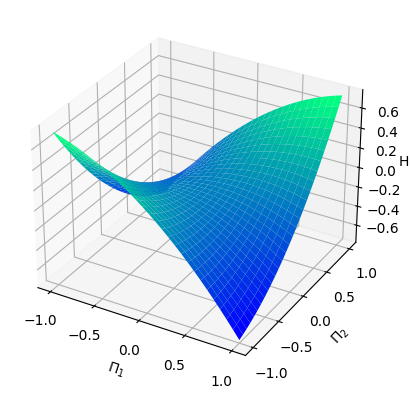

In [7]:
#Plot Ground Truth Hamiltonian
x = np.linspace(-1*lim, lim, 30)
y = np.linspace(-1*lim, lim, 30)

X, Y = np.meshgrid(x, y)
Z = torch.zeros((30,30))
for i in range(30):
    for j in range(30):
        Z[i,j] = Ham(torch.Tensor([X[i][j],Y[i][j],0,0,0,0,0,0,0]))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.get_cmap('winter'))
ax.set_xlabel(r'$\Pi_1$')
ax.set_ylabel(r'$\Pi_2$')
ax.set_zlabel('H', rotation=0)
ax.zaxis.labelpad=-1
# plt.savefig("Groundtruth_Lie_Poisson_Under_Water_Vehicle.png", bbox_inches='tight')
plt.show()

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter(train_data[:,0].detach().numpy(), train_data[:,1].detach().numpy(), color = "black")
# plt.show()

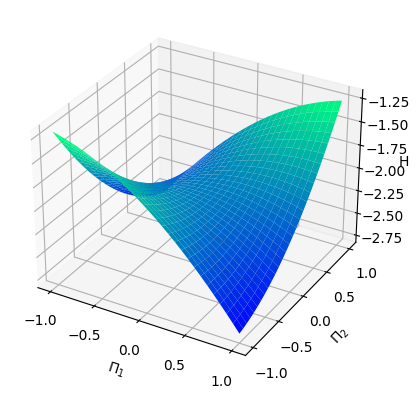

In [8]:
#Plot Predicted Hamiltonian
x = np.linspace(-1*lim, lim, 30)
y = np.linspace(-1*lim, lim, 30)

X, Y = np.meshgrid(x, y)
Z = torch.zeros((30,30))
for i in range(30):
    for j in range(30):
        Z[i,j] = prediction(torch.tensor([X[i][j],Y[i][j],0,0,0,0,0,0,0], dtype=torch.float32), rho)
Z = Z.detach().numpy()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.get_cmap('winter'))
ax.set_xlabel(r'$\Pi_1$')
ax.set_ylabel(r'$\Pi_2$')
ax.set_zlabel('H', rotation=0)
ax.zaxis.labelpad=-1
plt.savefig("Learned_Lie_Poisson_Under_Water_Vehicle.png", bbox_inches='tight')
plt.show()

In [ ]:
#Plot Hamiltonian Vector Field Error
grid = 40
x = np.linspace(-1*lim, lim, grid)
y = np.linspace(-1*lim, lim, grid)

X, Y = np.meshgrid(x, y)
Z = torch.zeros((grid,grid))
for i in range(grid):
    for j in range(grid):
        U = Ham_Vec_Field(torch.tensor([[X[i][j],Y[i][j],0,0,0,0,0,0,0]], dtype=torch.float32, requires_grad = True),0)
        V = Prediction_Ham_Vec_Field(train_data, torch.tensor([X[i][j],Y[i][j],0,0,0,0,0,0,0], dtype=torch.float32), c_hat, rho)
        Z[i,j] = torch.norm(U-V, p=2)
        
Ham_vec_error = Z.detach().numpy()
ax = sns.heatmap(Ham_vec_error, cmap='jet')
ax.yaxis.set_label_coords(-0.1,1.02)
ax.set_xticks(np.linspace(0,grid,3))
ax.set_xticklabels(f'{c:.1f}' for c in range(-1,2))
ax.set_yticks(np.linspace(0,grid,3))
ax.set_yticklabels(f'{c:.1f}' for c in range(-1,2))
plt.xticks(rotation=0)
plt.xlabel(r'$\Pi_1$')
plt.ylabel(r'$\Pi_2$', rotation=0)
plt.savefig("Vector_Field_Lie_Poisson_Under_Water_Vehicle.png", bbox_inches='tight')
plt.show()